In [90]:
%pip install tensorflow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [91]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [92]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [93]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [94]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

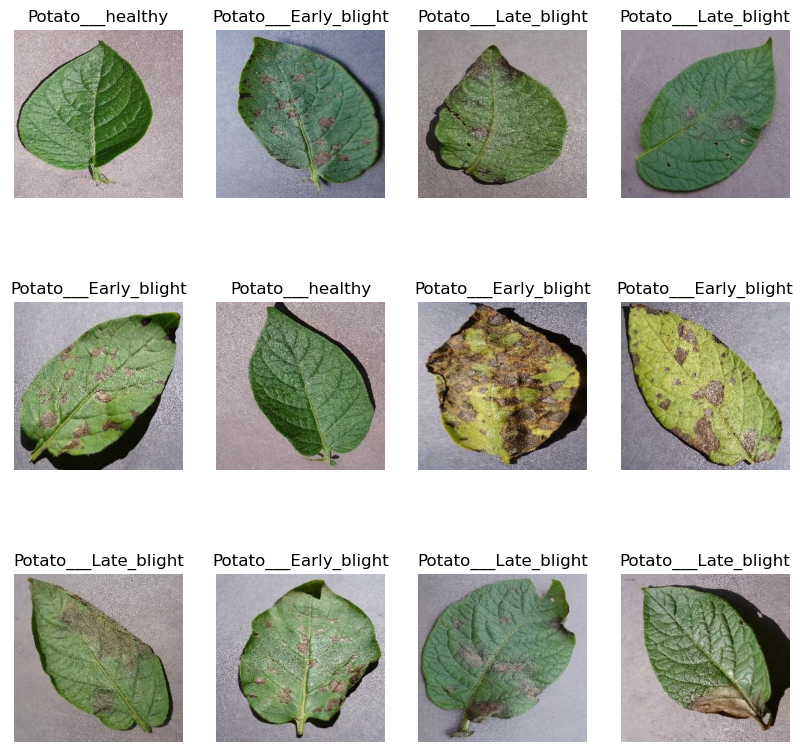

In [95]:
plt.figure(figsize=(10, 10))

for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [96]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [97]:
train_dataset = dataset.take(54) 
len(train_dataset)

54

In [98]:
test_dataset = dataset.skip(54)
len(test_dataset)

14

In [99]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [100]:
val_dataset = test_dataset.take(6)
len(val_dataset)

6

In [101]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

8

In [102]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset
    

In [103]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [104]:
len(train_dataset), len(val_dataset), len(test_dataset)

(54, 6, 8)

In [105]:
train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [106]:
resize_and_rescale = tf.keras.Sequential([
   layers.Rescaling(1.0/255),
   layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)
])

In [107]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [108]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [109]:
model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [110]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [112]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 507ms/step - accuracy: 0.5012 - loss: 0.9149 - val_accuracy: 0.6042 - val_loss: 0.9133
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 497ms/step - accuracy: 0.8087 - loss: 0.5877 - val_accuracy: 0.8690 - val_loss: 0.3414
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 498ms/step - accuracy: 0.8400 - loss: 0.4105 - val_accuracy: 0.8438 - val_loss: 0.3359
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 482ms/step - accuracy: 0.8718 - loss: 0.3107 - val_accuracy: 0.8958 - val_loss: 0.2021
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 481ms/step - accuracy: 0.9168 - loss: 0.2068 - val_accuracy: 0.8854 - val_loss: 0.2328
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 465ms/step - accuracy: 0.9080 - loss: 0.2102 - val_accuracy: 0.9167 - val_loss: 0.1991
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 475ms/step - accuracy: 0.9141 - loss: 0.2262 - val_accuracy: 0.8854 - val_loss: 0.3525
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 497ms/step - accuracy: 0.9182 - loss: 0.2235 - val_accuracy: 0.942

In [113]:
scores = model.evaluate(test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9136 - loss: 0.2152


In [114]:
scores

[0.1946140080690384, 0.921875]

In [115]:
history

In [116]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [117]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [118]:
history.history['accuracy']

[0.5613425970077515,
 0.8204225301742554,
 0.8421361446380615,
 0.8826290965080261,
 0.9125586748123169,
 0.9119718074798584,
 0.9196009635925293,
 0.9248826503753662,
 0.9196009635925293,
 0.9272300601005554]

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

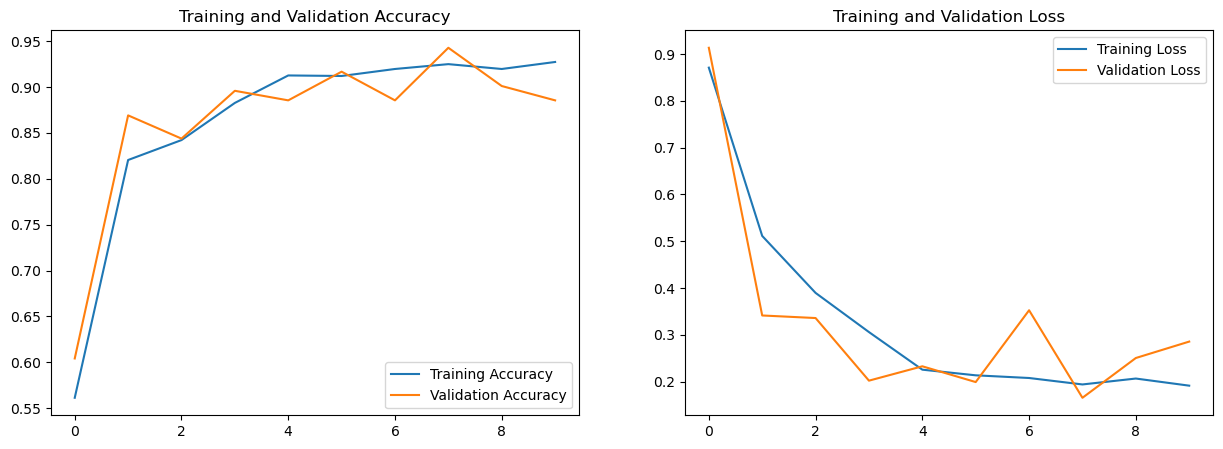

In [120]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
predicted label: Potato___Early_blight


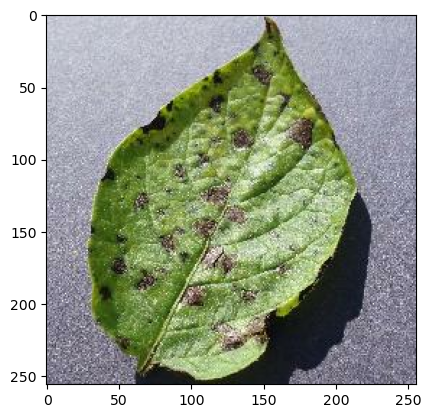

In [121]:
import numpy as np


for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    
    
    print(f'First image')
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [122]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


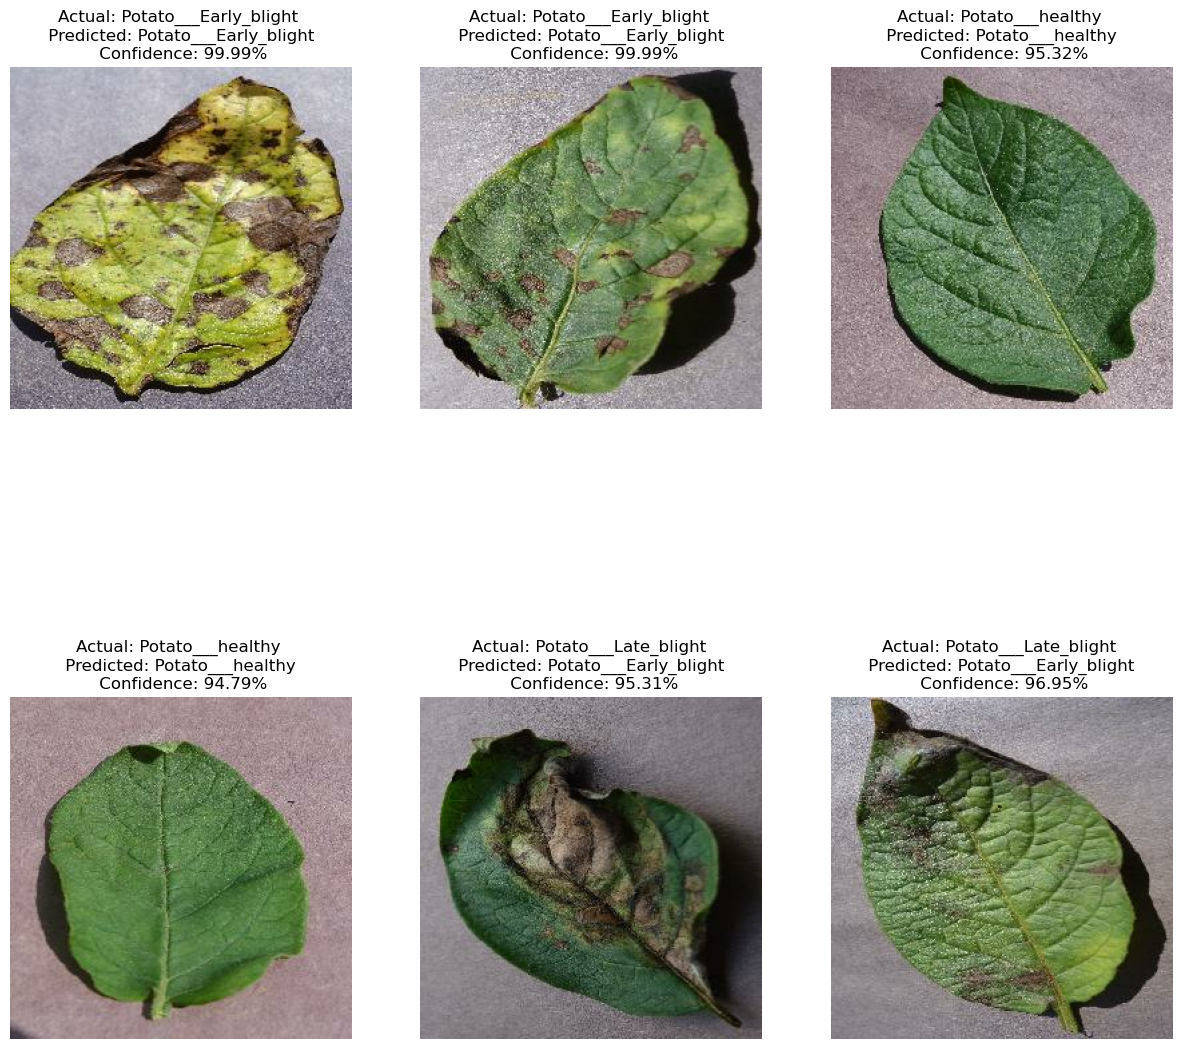

In [123]:
plt.figure(figsize=(15, 15))

for images, labels in test_dataset.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence}%")
        
        plt.axis('off')
       

In [124]:
import os 
model_version = max([int(i.split("_")[-1]) for i in os.listdir("models")]) +1
print(model_version)

model.save(f"models/mash_net_{model_version}.keras")

3
